In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Prediction model

In [5]:
# load packages
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
from pathlib import Path
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
from scipy import ndimage
import seaborn as sns

In [6]:
# set params
data_path = '/content/drive/MyDrive/BIA4_ICA/glaucoma-detection/'
meta_path = os.path.join(data_path, 'glaucoma.csv')
images_path = os.path.join(data_path, 'ORIGA/ORIGA/Images/*.jpg')
img_root_path = os.path.join(data_path, "ORIGA/ORIGA/Images")
save_path = os.path.join(data_path, "working/cropped_images")
os.makedirs(save_path, exist_ok=True)

In [7]:
meta = pd.read_csv(meta_path)
all_images = glob(images_path)
meta["Path"] = meta["Filename"].apply(lambda fn: os.path.join(img_root_path, fn))

In [8]:
def segment_optic_disc(all_images, save_path, threshold=10):
    import cv2
    import numpy as np
    from pathlib import Path
    from sklearn.cluster import KMeans
    from tqdm.notebook import tqdm
    import os

    def gamma_correct(img, gamma=0.4):
        img = img.astype(np.uint8)
        lookUpTable = np.empty((1,256), np.uint8)
        for i in range(256):
            lookUpTable[0,i] = np.clip(pow(i / 255.0, gamma) * 255.0, 0, 255)
        out = cv2.LUT(img, lookUpTable)
        return out

    def clahe(image, cl=2.0, tgs=8):
        clahe_ = cv2.createCLAHE(clipLimit=cl, tileGridSize=(tgs, tgs))
        cl1 = clahe_.apply(image)
        return cl1

    def clahe_rgb(img, cl=2.0, tgs=8):
        g, b, r = cv2.split(img)
        g, b, r = clahe(g), clahe(b), clahe(r)
        return cv2.merge([g, b, r])

    def apply_gaussian(img):
        img = cv2.GaussianBlur(img, (5,5), 0)
        return img

    def get_bounding_box(mask):
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnt = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(cnt)
        return [x, y, w, h]

    def remove_black_padding(img, threshold):
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        _, th = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)

        x, y, w, h = get_bounding_box(th)

        c_size = 300
        final_size = 224
        images = []

        for i, image in enumerate([clahe(gray), gamma_correct(gray, 3), clahe_rgb(img), img]):
            crop = image[y+c_size:y+h-c_size, x+c_size:x+w-c_size]
            crop_resized = cv2.resize(crop, (final_size, final_size))
            if i == 2:
                images.append(crop)
            images.append(crop_resized)

        return images

    def ensure_cluster_groups(data_2d, labels, clusters=4):
        mean_intensities = [data_2d[labels == i].mean() for i in range(clusters)]
        label_map = {i: label for i, label in sorted(enumerate(mean_intensities), key=lambda x: x[1])}
        label_map = {k: i for i, k in enumerate(label_map.keys())}
        mapped_labels = np.vectorize(label_map.get)(labels)
        return mapped_labels

    def cluster_image(img):
        data_2d = img.reshape(-1, 1)
        kmeans = KMeans(n_clusters=6, n_init=3, random_state=0).fit(data_2d)
        labels = kmeans.labels_
        labels = ensure_cluster_groups(data_2d, labels, 6)
        labels = labels.reshape(img.shape)
        mask = np.isin(labels, [4, 5])
        mask = (mask * 255).astype(np.uint8)
        return mask

    def apply_morphology(binary_mask):
        kernel = np.ones((5,5),np.uint8)
        opening = cv2.morphologyEx(binary_mask, cv2.MORPH_OPEN, kernel, iterations = 1)
        final = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel, iterations = 2)
        return final

    def crop_cup_disc(img, mask):
        x, y, w, h = get_bounding_box(mask)
        width_ratio = img.shape[1]/mask.shape[1]
        height_ratio = img.shape[0]/mask.shape[0]
        x, w = int(x * width_ratio), int(w * width_ratio)
        y, h = int(y * height_ratio), int(h * height_ratio)

        cx = x + w//2
        cy = y + h//2

        c_size = 300
        x_start = (cx-c_size) if (cx > c_size) else 0
        y_start = (cy-c_size) if (cy > c_size) else 0

        crop = img[y_start:cy+c_size, x_start:cx+c_size]
        crop = cv2.resize(crop, (224, 224))

        return crop

    for image_path in tqdm(all_images):
        image_name = Path(image_path).parts[-1]
        new_path = os.path.join(save_path, image_name)

        img = cv2.imread(image_path)

        # original returns 5 items
        _, corrected_gray, rgb_clahe_org, _, _ = remove_black_padding(img, threshold)

        segmented = cluster_image(corrected_gray)
        segmented = apply_morphology(segmented)

        rgb_cup = crop_cup_disc(rgb_clahe_org, segmented)

        cv2.imwrite(new_path, rgb_cup)

    print("Finished processing all images!")

In [9]:
segment_optic_disc(all_images, save_path, threshold=10)


  0%|          | 0/650 [00:00<?, ?it/s]

Finished processing all images!


In [10]:
meta["Seg_Path"] = meta["Filename"].apply(lambda fn: os.path.join(save_path, fn))
meta_gl = meta.loc[meta["Glaucoma"] == 0]
meta_nl = meta.loc[meta["Glaucoma"] == 1]
new_meta = pd.concat([meta_gl.iloc[:170], meta_nl]).copy()
print(new_meta)

    Filename  ExpCDR Eye Set  Glaucoma  \
0    001.jpg  0.7097  OD   A         0   
1    002.jpg  0.6953  OS   A         0   
2    003.jpg  0.9629  OS   A         0   
3    004.jpg  0.7246  OD   A         0   
4    005.jpg  0.6138  OS   A         0   
..       ...     ...  ..  ..       ...   
644  645.jpg  0.7111  OS   A         1   
645  646.jpg  0.6560  OD   A         1   
646  647.jpg  0.7365  OD   A         1   
647  648.jpg  0.5101  OS   A         1   
649  650.jpg  0.6195  OS   B         1   

                                                  Path  \
0    /content/drive/MyDrive/BIA4_ICA/glaucoma-detec...   
1    /content/drive/MyDrive/BIA4_ICA/glaucoma-detec...   
2    /content/drive/MyDrive/BIA4_ICA/glaucoma-detec...   
3    /content/drive/MyDrive/BIA4_ICA/glaucoma-detec...   
4    /content/drive/MyDrive/BIA4_ICA/glaucoma-detec...   
..                                                 ...   
644  /content/drive/MyDrive/BIA4_ICA/glaucoma-detec...   
645  /content/drive/MyDrive/BIA

In [11]:
from skimage.io import imread
from skimage.transform import resize
def load_image(row):
    image_path = row["Seg_Path"]
    im = imread(image_path)
    im = resize(im, IMAGE_SIZE)
    return im

In [12]:
new_meta['image'] = new_meta.apply(load_image, axis=1)

In [13]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(new_meta, test_size=0.25, random_state=42)
train_df.shape, test_df.shape

((253, 8), (85, 8))

In [14]:
X_image_train = train_df['image']
y_train = train_df['Glaucoma']

In [15]:
X_image_test = test_df['image']
# X_data_test = test_df[['ExpCDR', 'eye', 'set']]
y_test = test_df['Glaucoma']

In [16]:
X_image_train_stacked = np.stack(X_image_train.values)
X_image_test_stacked = np.stack(X_image_test.values)

In [17]:
import tensorflow as tf

IMG_SIZE = 224
BATCH = 16

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_df["Seg_Path"], train_df["Glaucoma"]))
test_ds   = tf.data.Dataset.from_tensor_slices((test_df["Seg_Path"],   test_df["Glaucoma"]))

train_ds = train_ds.map(load_image).shuffle(1000).batch(BATCH).prefetch(1)
test_ds   = test_ds.map(load_image).batch(BATCH).prefetch(1)


In [18]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights
class_weight_dict = {
    0: class_weights[0],
    1: class_weights[1]
}
class_weight_dict

{0: np.float64(1.0201612903225807), 1: np.float64(0.9806201550387597)}

In [19]:
import tensorflow as tf
from tensorflow.keras import Sequential, layers, Model, Input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from sklearn.metrics import classification_report

In [20]:
IMAGE_SIZE = (224,224)

In [21]:
resnet = ResNet50(input_shape=IMAGE_SIZE+(3,), weights='imagenet', include_top=False)
vgg = VGG16(input_shape=IMAGE_SIZE+(3,), weights='imagenet', include_top=False)
xception = Xception(input_shape=IMAGE_SIZE+(3,), weights='imagenet', include_top=False)
resnet101 = ResNet101(input_shape=IMAGE_SIZE+(3,), weights='imagenet', include_top=False)
inception = InceptionV3(input_shape=IMAGE_SIZE+(3,), weights='imagenet', include_top=False)
mobilenet = MobileNetV2(input_shape=IMAGE_SIZE+(3,), weights='imagenet', include_top=False)
efficientnet = EfficientNetB7(input_shape=IMAGE_SIZE+(3,), weights='imagenet', include_top=False)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [22]:
model_dict = {
    'resnet50': resnet,
    'vgg16': vgg,
    'xception': xception,
    'resnet101': resnet101,
    'inception': inception,
    'mobilenet': mobilenet,
    'efficientnetB7': efficientnet
}
model_dict

{'resnet50': <Functional name=resnet50, built=True>,
 'vgg16': <Functional name=vgg16, built=True>,
 'xception': <Functional name=xception, built=True>,
 'resnet101': <Functional name=resnet101, built=True>,
 'inception': <Functional name=inception_v3, built=True>,
 'mobilenet': <Functional name=mobilenetv2_1.00_224, built=True>,
 'efficientnetB7': <Functional name=efficientnetb7, built=True>}

In [23]:
for key, model in model_dict.items():
    for layer in model.layers:
        layer.trainable = False

In [24]:
history_dict = {}
for key, model in model_dict.items():
    x = layers.Flatten()(model.output)
    prediction = layers.Dense(1, activation='sigmoid')(x)
    model = Model(inputs=model.input, outputs=prediction)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # print(key)
    # print(model.summary())
    # model.fit(X_image_train_stacked, y_train, class_weight=class_weight_dict, epochs=10)

    history = model.fit(
        X_image_train_stacked, y_train,
        class_weight=class_weight_dict,
        epochs=10,
        validation_data=(X_image_test_stacked, y_test),
        verbose=1
    )

    history_dict[key] = history

    y_pred = model.predict(X_image_test_stacked)
    y_pred = [round(y[0]) for y in y_pred]
    print(classification_report(y_test, y_pred))

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 74s 8s/step - accuracy: 0.5075 - loss: 2.3678 - val_accuracy: 0.5412 - val_loss: 2.2614
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 57s 7s/step - accuracy: 0.4750 - loss: 2.0080 - val_accuracy: 0.5412 - val_loss: 1.1177
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 61s 8s/step - accuracy: 0.4876 - loss: 1.3038 - val_accuracy: 0.5882 - val_loss: 0.6712
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.5081 - loss: 1.1397 - val_accuracy: 0.4588 - val_loss: 1.0455
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.5016 - loss: 0.9200 - val_accuracy: 0.4588 - val_loss: 0.8674
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 84s 9s/step - accuracy: 0.5199 - loss: 0.7917 - val_accuracy: 0.4941 - val_loss: 0.7057
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.5769 - loss: 0.6514 - val_accuracy: 0.5529 - val_loss: 0.6844
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.6769 - loss: 0.6128 - val_accuracy: 0.5765 - val_loss: 0.7008
Epoch 9/

2/3 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step 

3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 6s/step
              precision    recall  f1-score   support

           0       0.79      0.74      0.76        46
           1       0.71      0.77      0.74        39

    accuracy                           0.75        85
   macro avg       0.75      0.75      0.75        85
weighted avg       0.76      0.75      0.75        85

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 140s 16s/step - accuracy: 0.5276 - loss: 1.6987 - val_accuracy: 0.4588 - val_loss: 1.5924
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 100s 13s/step - accuracy: 0.4916 - loss: 1.1712 - val_accuracy: 0.4588 - val_loss: 1.2320
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 115s 15s/step - accuracy: 0.5133 - loss: 0.9558 - val_accuracy: 0.4588 - val_loss: 1.1574
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 116s 15s/step - accuracy: 0.4766 - loss: 0.9996 - val_accuracy: 0.4588 - val_loss: 0.9693
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 100s 13s/step - accuracy: 0.5528 - loss: 0.7218 - val_accuracy: 0.4706 - val_loss: 0.8672
Epoch 

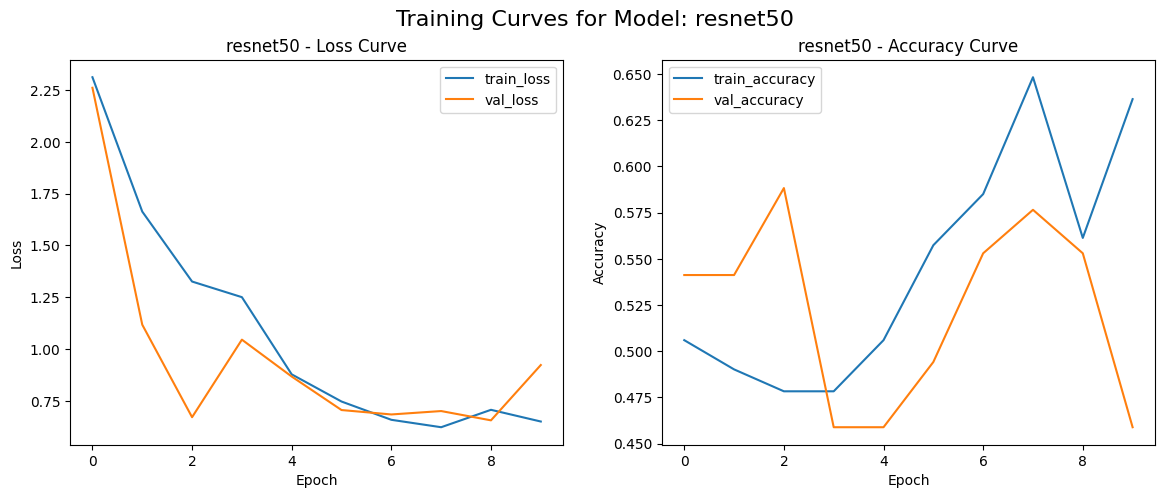

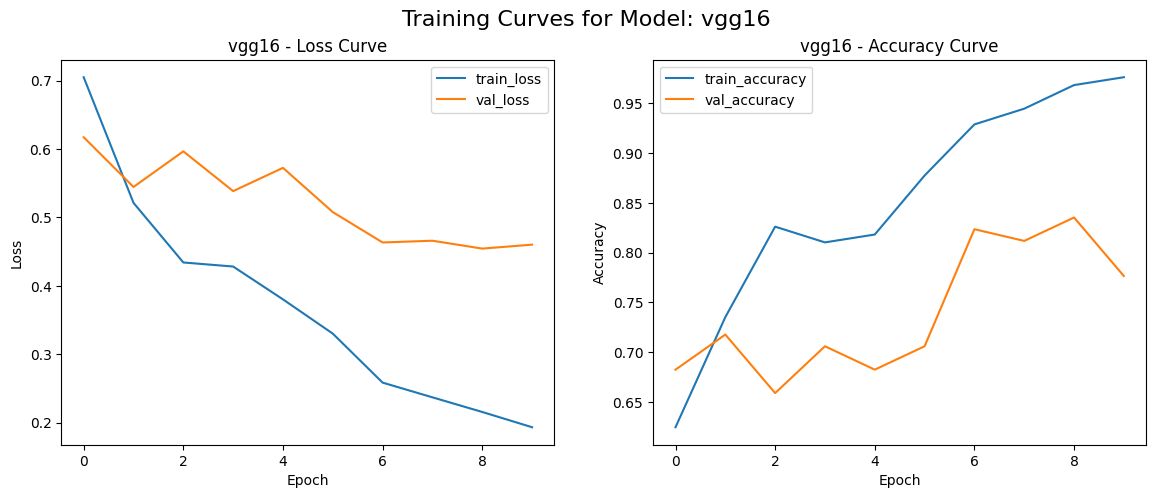

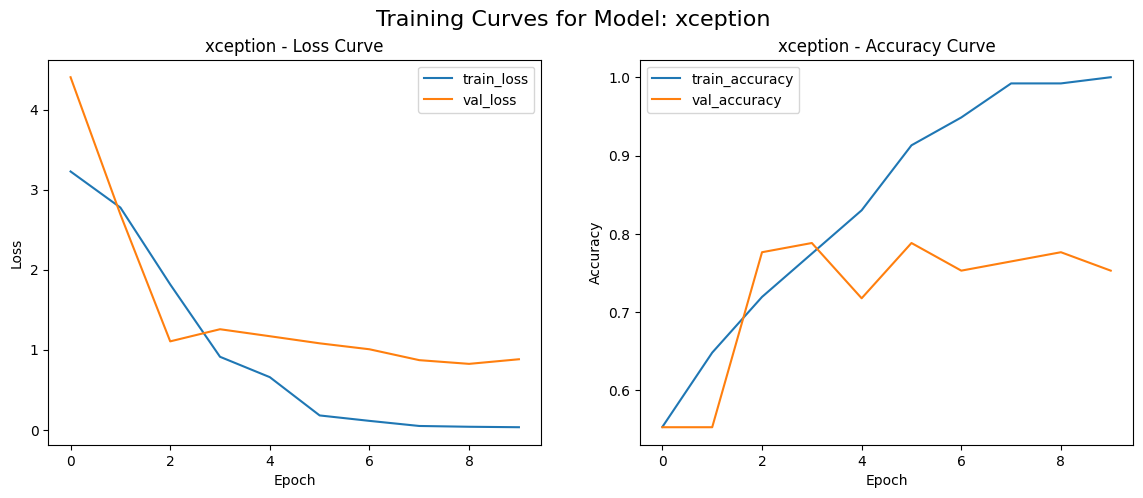

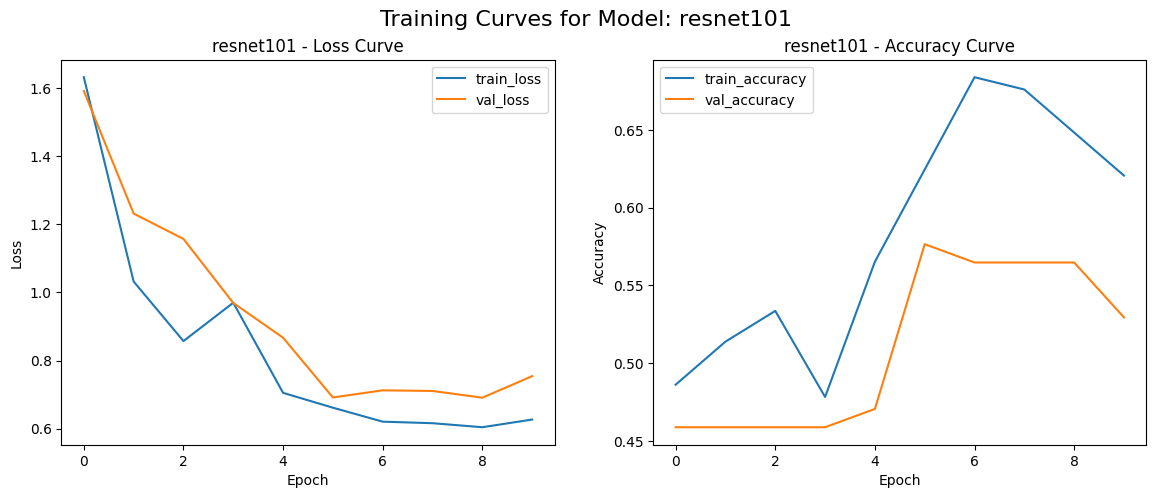

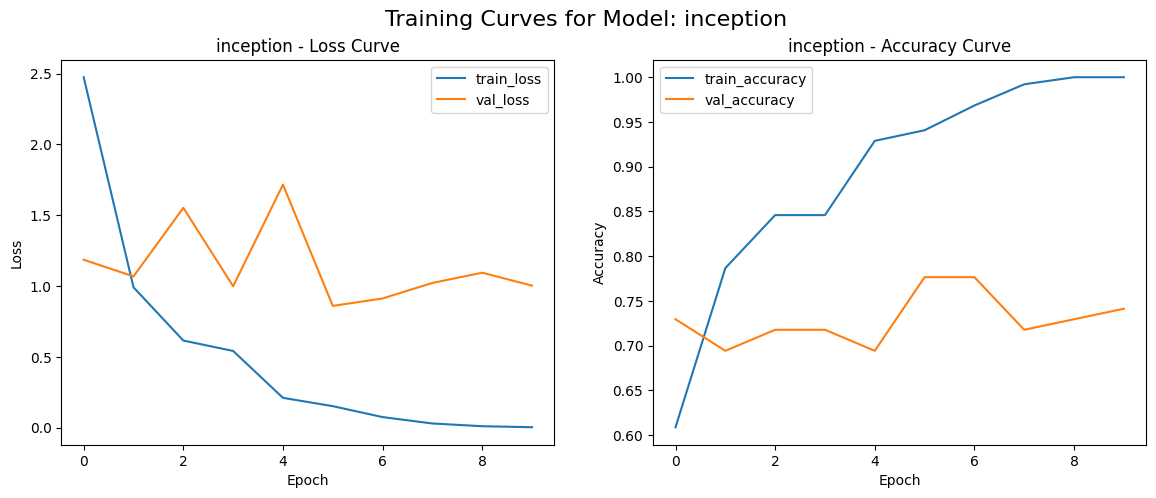

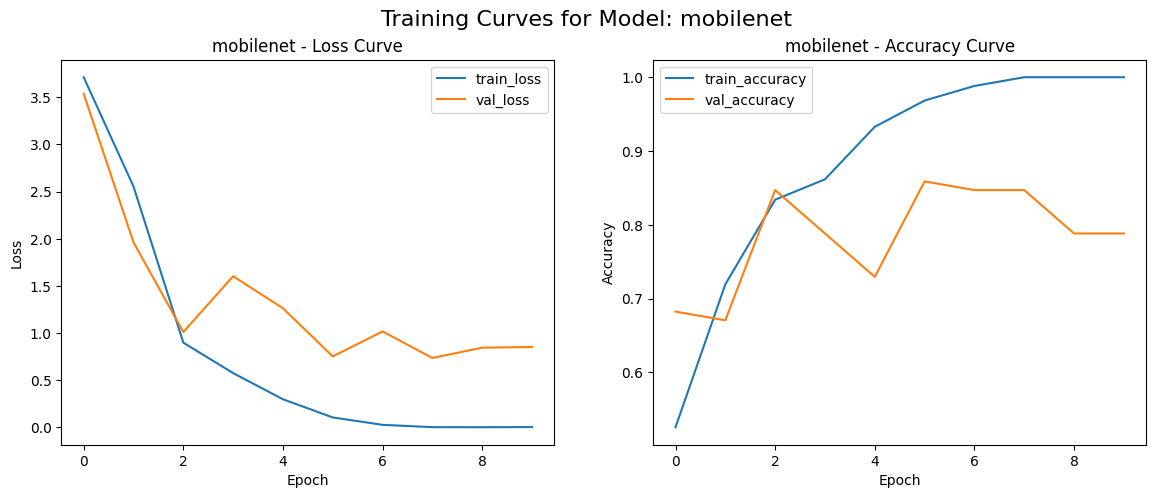

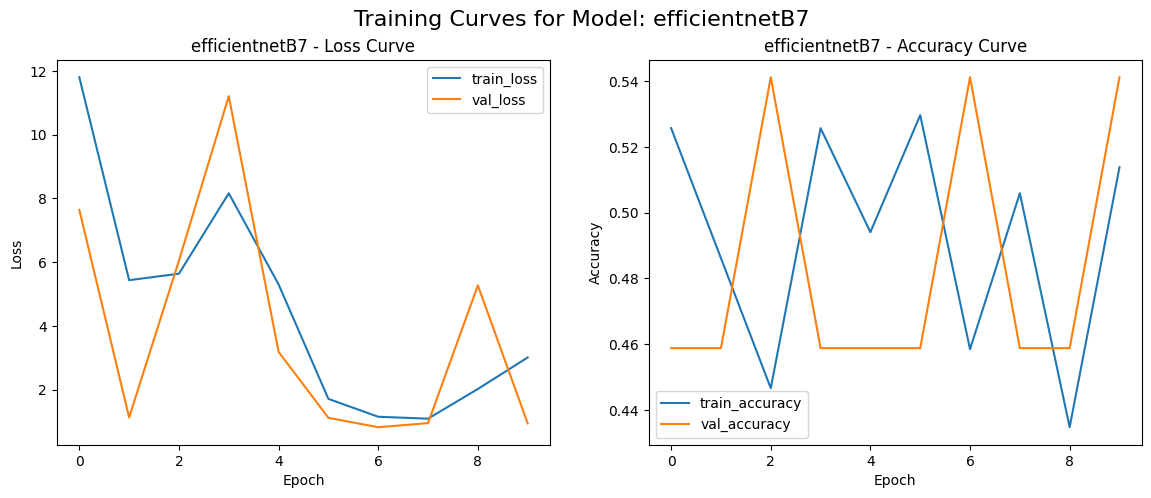

In [25]:
import matplotlib.pyplot as plt

for key, history in history_dict.items():
    hist = history.history

    plt.figure(figsize=(14,5))

    # ---------------- Loss ----------------
    plt.subplot(1,2,1)
    plt.plot(hist['loss'], label='train_loss')
    plt.plot(hist['val_loss'], label='val_loss')
    plt.title(f'{key} - Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # ---------------- Accuracy ----------------
    plt.subplot(1,2,2)
    plt.plot(hist['accuracy'], label='train_accuracy')
    plt.plot(hist['val_accuracy'], label='val_accuracy')
    plt.title(f'{key} - Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.suptitle(f"Training Curves for Model: {key}", fontsize=16)
    plt.show()
